## Task - 3 Correlation Analysis

#### Data Preparation

In [1]:
import os
import pandas as pd
import yfinance as yf
import nltk
from textblob import TextBlob
import numpy as np
import sys
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_directory)

# Insert the parent directory into sys.path
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
scripts_dir = os.path.join(parent_dir, 'scripts')
sys.path.insert(0, scripts_dir)

# Now I can import my module
from scripts.main import DataPreprocessing

#### Normalize Dates of News and load data

In [3]:
file_path = { 
    "Row-Analysis-Ratings": "https://drive.google.com/uc?export=download&id=1MC0ePKh2oc3VqGtOMNTboyICpyuiSr2l"
}
preprocesor = DataPreprocessing(file_path)
data_frames = preprocesor.process_file()
df = data_frames.get("Row-Analysis-Ratings")
df
# Convert the 'date' column to datetime format and UTC-4 timezone
df['date'] = pd.to_datetime(df['date'], format='ISO8601', utc=True)

Data for Row-Analysis-Ratings loaded successfully.


#### Normalize data of stock and load data 

In [19]:
import yfinance as yf
import pandas as pd

# Fetch stock prices using yfinance
def fetch_stock_data(symbol, start_date, end_date):
    ticker = yf.Ticker(symbol)
    return ticker.history(start=start_date, end=end_date)

# List of specific companies
symbols = ["AAPL", "AMZN", "GOOG", "NVDA", "TSLA"]

# Calculate date ranges for each of the stocks
date_ranges = {}
for symbol in symbols:
    symbol_data = df[df['stock'] == symbol]
    start_date = pd.to_datetime(symbol_data['date'].min(), utc=True)
    end_date = pd.to_datetime(symbol_data['date'].max(), utc=True)
    
    # Localize naive timestamps to UTC
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize(None)
    else:
        start_date = start_date.tz_convert('UTC')
    
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')
    else:
        end_date = end_date.tz_convert('UTC')
    
    date_ranges[symbol] = (start_date, end_date)

# Fetch stock prices and align with dates
stock_data = {}
for symbol, (start_date, end_date) in date_ranges.items():
    if pd.notnull(symbol):  # Check if symbol is not NaN
        try:
            stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)
        except ValueError as e:
            print(f"Error fetching data for {symbol}: {e}")

# Now stock_data contains the historical prices for the specified companies

#### Perform Sentiment analysis

In [20]:
# Sentiment Analysis using TextBlob
def get_sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

#### Compute Daily returns and calculate correlation

In [21]:
# Calculate Daily Stock Returns and Sentiment Scores for each stock
correlation_coefficients = {}
for symbol in symbols:
    if symbol in stock_data:  # Check if symbol is in stock_data
        news_data = df[df['stock'] == symbol]
        news_data = news_data.copy()  # Create a copy of news_data to avoid the SettingWithCopyWarning
        news_data.rename(columns={"date": "Date"}, inplace=True)
        stock_df = pd.DataFrame(stock_data[symbol])
        merged_data = pd.merge(stock_df, news_data, on='Date')

        # Apply Sentiment Analysis to headlines
        merged_data['Sentiment_Score'] = merged_data['headline'].apply(get_sentiment_score)

        # Calculate Daily Stock Returns
        merged_data['Daily_Return'] = merged_data['Close'].pct_change()

        # Calculate daily average sentiment scores by aggregating sentiment scores for each day
        daily_sentiment = merged_data.groupby(merged_data['Date'].dt.date)['Sentiment_Score'].mean().reset_index()

        # Convert 'Date' column to datetime in both dataframes
        merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='ISO8601', utc=True).dt.normalize()
        daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], format='ISO8601', utc=True).dt.normalize()

        # Rename 'Sentiment_Score' column in 'daily_sentiment'
        daily_sentiment.rename(columns={"Sentiment_Score": "Daily_Avg_Sentiment_Score"}, inplace=True)

        # Merge daily stock returns with daily average sentiment scores
        merged_data = pd.merge(merged_data, daily_sentiment, on='Date')

        # Compute the correlation coefficient
        correlation_coefficient = merged_data['Daily_Return'].corr(merged_data['Sentiment_Score'])
        correlation_coefficients[symbol] = correlation_coefficient

##### Visualize correlation 

Correlation Coefficient between Daily Stock Returns and Sentiment Scores for AAPL: 0.14217756068550044
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for AMZN: -0.06954668441898432
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for GOOG: 0.06771413866335002
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for NVDA: 0.00283029527175746
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for TSLA: 0.021412265638911056


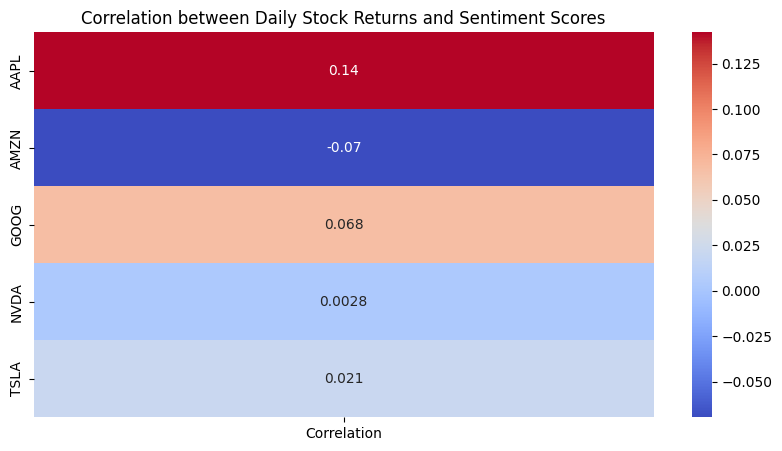

In [22]:
# Print Correlation Coefficients
for symbol, correlation in correlation_coefficients.items():
    print(f"Correlation Coefficient between Daily Stock Returns and Sentiment Scores for {symbol}: {correlation}")

# Visualization
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(correlation_coefficients, index=['Correlation']).T, annot=True, cmap='coolwarm')
plt.title('Correlation between Daily Stock Returns and Sentiment Scores')
plt.show()